In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score

**Reading data.** 

In [125]:
# reading the data 
df = pd.read_csv("bank-additional-full.csv", delimiter=';')

In [126]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [127]:
list_numerical_data_types = [x for x in zip(df.dtypes.index, df.dtypes) if x[1] == object]
list_numerical_data_types

[('job', dtype('O')),
 ('marital', dtype('O')),
 ('education', dtype('O')),
 ('default', dtype('O')),
 ('housing', dtype('O')),
 ('loan', dtype('O')),
 ('contact', dtype('O')),
 ('month', dtype('O')),
 ('day_of_week', dtype('O')),
 ('poutcome', dtype('O')),
 ('y', dtype('O'))]

In [128]:
len(list_numerical_data_types)

11

In [129]:
df.shape

(41188, 21)

**Dropping duration column.** 

In [130]:
df.drop('duration', axis = 1, inplace=True)

**Label encoding and one-hot encoding.** 

In [131]:
# label encoding and one hot encoding
from sklearn.preprocessing import LabelEncoder

In [132]:
lbn = LabelEncoder()

In [133]:
df['y'] = lbn.fit_transform(df.y)

In [134]:
df = pd.get_dummies(df, drop_first = True)

In [135]:
df.shape

(41188, 53)

**Checking missing values.** 

In [136]:
# checking missing values

In [137]:
df.isnull().sum()

age                              0
campaign                         0
pdays                            0
previous                         0
emp.var.rate                     0
cons.price.idx                   0
cons.conf.idx                    0
euribor3m                        0
nr.employed                      0
y                                0
job_blue-collar                  0
job_entrepreneur                 0
job_housemaid                    0
job_management                   0
job_retired                      0
job_self-employed                0
job_services                     0
job_student                      0
job_technician                   0
job_unemployed                   0
job_unknown                      0
marital_married                  0
marital_single                   0
marital_unknown                  0
education_basic.6y               0
education_basic.9y               0
education_high.school            0
education_illiterate             0
education_profession

In [138]:
# as above no missing values present in given dataset

**Checking imbalance in dataset using histogram.** 

In [139]:
imabalance_info = (df.y.value_counts() / df.shape[0])
imabalance_info

0    0.887346
1    0.112654
Name: y, dtype: float64

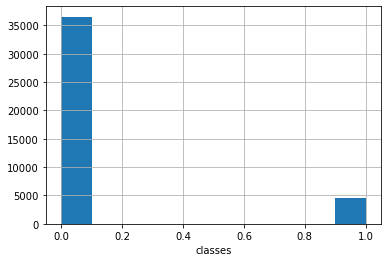

In [140]:
df.y.hist()
plt.xlabel("classes")
plt.show()


In [141]:
# from above we can see that data is imbalance
# Most of the readings are from 0 class around 88% readings are belongs to class '0'

**Splitting the data.** 

In [142]:
# splitting the data

In [143]:
from sklearn.model_selection import train_test_split

In [144]:
X = df.drop('y', axis = 1)
y = df.y

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)

**k-fold cross validation on random forest.** 

In [146]:
# model training using k-fold cross validation on random forest algo

In [147]:
from sklearn.metrics import f1_score

In [153]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=100,max_depth=8
)

In [156]:
def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [152]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

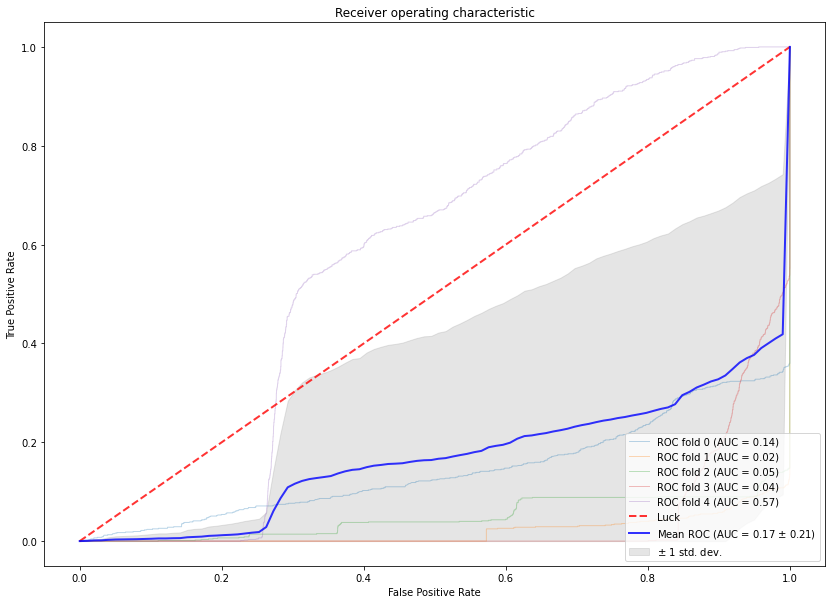

,AUC Train,AUC Test
0,0.901909,0.143910
1,0.893773,0.020689
2,0.876472,0.048468
3,0.847500,0.044969
4,0.850212,0.569739


In [157]:
cv = StratifiedKFold(n_splits=5)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X, y), range(100)):
    clf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [158]:
y_pred = clf.predict(X_test)


In [159]:
f1_score(y_test, y_pred)

0.36701588374450833

In [160]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=400,max_depth=6
)

In [161]:
cv = StratifiedKFold(n_splits=5)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X, y), range(100)):
    clf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

In [162]:
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred)

0.3578231292517006

In [163]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=100,max_depth=12
)

In [165]:
clf.fit(X.iloc[train], y.iloc[train])

RandomForestClassifier(max_depth=12)

In [166]:
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred)

0.3838181210297559

In [168]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=750 ,max_depth=6, random_state=60
)

In [169]:
clf.fit(X.iloc[train], y.iloc[train])

RandomForestClassifier(max_depth=6, n_estimators=750, random_state=60)

In [170]:
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred)

0.3579448792106159

In [171]:
imp = pd.DataFrame({"features": X.columns, "importance": clf.feature_importances_})

In [172]:
importance.sort_values('importance', ascending = False).iloc[:3]

,features,importance
8,nr.employed,0.258872
7,euribor3m,0.215105
4,emp.var.rate,0.109756


**Gridsearch using random forest.** 

In [78]:
from sklearn.model_selection  import GridSearchCV

In [80]:
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [50, 70],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 70]})

In [82]:
pred = CV_rfc.predict(X_test)

**Testing accuracy.** 

In [98]:
accuracy_score(y_test, pred)

0.8901432386501578

**Getting top-3 features** 

In [99]:
# getting top 3 features

In [100]:
importance = pd.DataFrame({"features": X.columns, "importance": clf.feature_importances_})

In [101]:
importance.sort_values('importance', ascending = False).iloc[:3]

,features,importance
8,nr.employed,0.258872
7,euribor3m,0.215105
4,emp.var.rate,0.109756


In [102]:
# above shown the top three features 